<a href="https://colab.research.google.com/github/kishanAk21/Image-Captioning/blob/main/Image_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import seaborn as sns
sns.set()
from collections import Counter
from nltk.corpus import stopwords

import keras
from sklearn.model_selection import train_test_split
import string
import os
import time
from PIL import Image
import glob
from pickle import dump, load
from time import time
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from tqdm.notebook import tqdm

import gc
gc.collect()

0

In [ ]:
# Mounting google drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip -qq "gdrive/MyDrive/img_cap.zip" -d ""

Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create word-to-index and index-to-word mappings.

4.Create a dataframe which summarizes the image, path & captions as a dataframe

5.Visualise the top 30 occuring words in the captions

6.Create a list which contains all the captions & path


In [ ]:
#Import the dataset and read the image into a seperate variable

images= 'Images/'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


In [ ]:
all_imgs[0:5]

['Images/1775029934_e1e96038a8.jpg',
 'Images/1184967930_9e29ce380d.jpg',
 'Images/2100816230_ff866fb352.jpg',
 'Images/2279496715_8ef3ee6edb.jpg',
 'Images/1089755335_0bfbfd30e6.jpg']

In [ ]:
len(all_imgs)

8091

In [ ]:
captions = pd.read_csv('captions.txt')
captions.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [ ]:
captions.shape

(40455, 2)

In [ ]:
captions.image.nunique()

8091

In [ ]:
captions['path'] = 'Images/' + captions.image
captions.head()

,image,caption,path
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,Images/1000268201_693b08cb0e.jpg
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,Images/1000268201_693b08cb0e.jpg
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,Images/1000268201_693b08cb0e.jpg
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,Images/1000268201_693b08cb0e.jpg
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,Images/1000268201_693b08cb0e.jpg


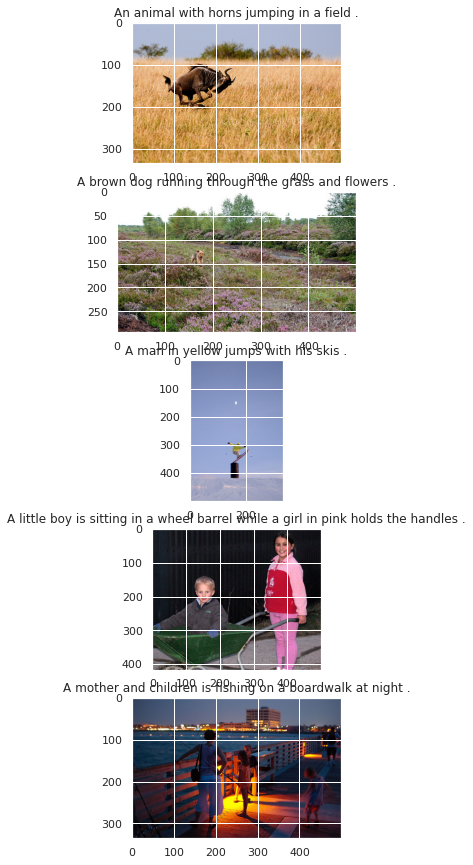

In [ ]:
#Visualise both the images & text present in the dataset

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(15)


for i in range(5):
    img = Image.open(all_imgs[i])
    
    plt.subplot(5,1,i+1)
    plt.imshow(img)
    plt.title(captions[captions.image==all_imgs[i].split('/')[1]].caption.values[0])


In [ ]:
#Create a list which contains all the captions
annotations=['<start> ' + sent + ' <end>' for sent in captions.caption]

#add the <start> & <end> token to all those captions as well

#Create a list which contains all the path to the images
all_img_path = list(captions.path)

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [ ]:
annotations[0:5]

['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>',
 '<start> A girl going into a wooden building . <end>',
 '<start> A little girl climbing into a wooden playhouse . <end>',
 '<start> A little girl climbing the stairs to her playhouse . <end>',
 '<start> A little girl in a pink dress going into a wooden cabin . <end>']

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [ ]:
num_words = 5000
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'

In [ ]:
# Create word-to-index and index-to-word mappings.

tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token, filters='!"#$%&()*+.-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(annotations)


In [ ]:
# Get our training data word index
# tokenizer.word_index

In [ ]:
index_seq = tokenizer.texts_to_sequences(annotations)
# index_seq[0:2]

In [ ]:
 # Padding
maxlen = max([len(sent) for sent in captions.caption.str.split()]) + 2
index_seq_padded = pad_sequences(index_seq, padding=pad_type,
                                 truncating=trunc_type, maxlen=maxlen)
index_seq_padded

array([[ 3,  2, 45, ...,  0,  0,  0],
       [ 3,  2, 20, ...,  0,  0,  0],
       [ 3,  2, 42, ...,  0,  0,  0],
       ...,
       [ 3,  2, 46, ...,  0,  0,  0],
       [ 3,  2, 87, ...,  0,  0,  0],
       [ 3,  2, 87, ...,  0,  0,  0]], dtype=int32)

In [ ]:
index_seq_padded.shape

(40455, 40)

## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

In [ ]:
BUFFER_SIZE = 1000
img_height = 299
img_width = 299
batch_size = 32
img_dims = (img_height, img_width)
data_dir = 'Images/'

In [ ]:
img_train, img_test, cap_train, cap_test = train_test_split(all_img_path, index_seq_padded,
                                                            test_size=0.2,random_state=42)

## Create the train & test data 
1.Combine both images & captions to create the train & test dataset using tf.data.Dataset API. Create the train-test spliit using 80-20 ratio & random state = 42

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 299, 299, 3)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [ ]:
# Creating tf batch dataset object

img_train = tf.constant(img_train)
img_test = tf.constant(img_test)

cap_train = tf.constant(cap_train)
cap_test = tf.constant(cap_test)


train_dataset = tf.data.Dataset.from_tensor_slices((img_train, cap_train))
test_dataset = tf.data.Dataset.from_tensor_slices((img_test, cap_test))


def _parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image_decoded = tf.image.resize(image_decoded, (img_height, img_width))
    image_decoded = preprocess_input(image_decoded)
    image = tf.cast(image_decoded, tf.float32)
    return image, label

train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_size)
test_dataset = test_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_size)

In [ ]:
# tf batch dataset object

type(train_dataset)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [ ]:
train_dataset

<BatchDataset shapes: ((None, 299, 299, 3), (None, 40)), types: (tf.float32, tf.int32)>

In [ ]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape) #(batch_size, 299, 299, 3)
print(sample_cap_batch.shape) #(batch_size, max_len)

(32, 299, 299, 3)
(32, 40)


## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the image using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(inputs=new_input, outputs=hidden_layer)

In [ ]:
from tqdm import tqdm
from tqdm.notebook import tqdm

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = preprocess_input(img)
    return img, image_path


encode_train = sorted(set(all_img_path))
feature_dict = {}
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)


for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    feature_dict[path_of_feature] =  bf.numpy()

  0%|          | 0/253 [00:00<?, ?it/s]

In [ ]:
# sample = image_features_extract_model(next(iter(train_dataset))[0])

# train_dataset_updated = image_features_extract_model(next(iter(train_dataset))[0]), next(iter(train_dataset))[1]

def map_func(img_name, cap):
  img_tensor = feature_dict[img_name.decode('utf-8')]
  return img_tensor, cap

In [ ]:
def gen_dataset(img_data, cap_data):
    
    dataset = tf.data.Dataset.from_tensor_slices((img_data, cap_data))
    dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_size)


    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [ ]:
train_dataset=gen_dataset(img_train,cap_train)
test_dataset=gen_dataset(img_test,cap_test)

In [ ]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,40)

(32, 64, 2048)
(32, 40)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [ ]:
embedding_dim = 256 
units = 512
vocab_size = 5001
train_num_steps = index_seq_padded.shape[0]*0.8// batch_size
test_num_steps = index_seq_padded.shape[0]*0.2// batch_size
features_shape = bf.shape[1]
attention_features_shape = bf.shape[0]

### Encoder

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim, activation='relu')
        
    def call(self, features):
        features =  self.dense(features)
        
        return features

In [ ]:
encoder=Encoder(embedding_dim)

### Attention model

In [ ]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis =  tf.expand_dims(hidden, axis=1)
        score = keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis)) 
        attention_weights =  keras.activations.softmax(self.V(score), axis=1)
        context_vector =  attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        

        return context_vector, attention_weights

### Decoder

In [ ]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)
        self.embed = layers.Embedding(vocab_size, embed_dim)
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = layers.Dense(self.units)
        self.d2 = layers.Dense(vocab_size)
        self.dropout = Dropout(0.5)
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        embed = self.dropout(self.embed(x)) 
        mask = self.embed.compute_mask(x)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1) 
        output, state = self.gru(embed, mask=mask) 
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2]))
        output = self.d2(output) 
        
        return output, state, attention_weights
    
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [ ]:
decoder = Decoder(embedding_dim, units, vocab_size)

In [ ]:
features = encoder(sample_img_batch)

hidden = decoder.reset_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (32, 64, 256)
Predcitions shape from Decoder: (32, 5001)
Attention weights shape from Decoder: (32, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [ ]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [ ]:
checkpoint_path = ''
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [ ]:
# @tf.function
def train_step(img_tensor, target):
  loss = 0
  hidden = decoder.reset_state(batch_size=target.shape[0])
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
  with tf.GradientTape() as tape:
    features = encoder(img_tensor)
    
    for i in range(1, target.shape[1]):
      output, hidden, _ = decoder(dec_input, features, hidden)
      loss += loss_function(target[:, i], output)
      dec_input = tf.expand_dims(target[:, i], 1)
      
  avg_loss = (loss / int(target.shape[1]))
    
  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  grads = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(grads, trainable_variables))
  
  return loss, avg_loss

In [ ]:

# class train_step():
#   def __init__(self, img_tensor, target):
#     self.img_tensor = img_tensor
#     self.target = target
#     self.loss = 0
#     self.hidden = decoder.reset_state(batch_size = self.target.shape[0])
#     self.dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * self.target.shape[0], 1)
  
#   @tf.function
#   def __call__(self):
#     with tf.GradientTape() as tape:
#       features = encoder(self.img_tensor)
      
#       for i in range(1, self.target.shape[1]):
#         output, self.hidden, _ = decoder(self.dec_input, features, self.hidden)
#         self.loss += loss_function(self.target[:, i], output)
#         self.dec_input = tf.expand_dims(self.target[:, i], 1)
      
#     avg_loss = (self.loss / int(self.target.shape[1]))
    
#     trainable_variables = encoder.trainable_variables + decoder.trainable_variables
#     grads = tape.gradient(self.loss, trainable_variables)
#     optimizer.apply_gradients(zip(grads, trainable_variables))
  
#     return self.loss, avg_loss

In [ ]:
# @tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    features = encoder(img_tensor)

    for i in range(1, target.shape[1]):
      output, hidden, _ = decoder(dec_input, features, hidden)
      loss += loss_function(target[:, i], output)
      dec_input = tf.expand_dims(tf.argmax(output, axis=1), 1)
      
    avg_loss = (loss / int(target.shape[1]))
    
    return avg_loss, loss

In [ ]:
def test_loss_cal(test_dataset):
  total_loss = 0
  
  for (batch, (img_tensor, target)) in enumerate(test_dataset):
    batch_loss, t_loss = test_step(img_tensor, target)
    
    total_loss += t_loss
    avg_test_loss=total_loss/test_num_steps
  return avg_test_loss

In [ ]:
import time

In [ ]:
loss_plot = []
test_loss_plot = []
EPOCHS = 5

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        # train_step = train_step()
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/5 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.177, & test loss is 72.987
Time taken for 1 epoch 1256.405023097992 sec

Test loss has been reduced from 100.000 to 72.987
For epoch: 2, the train loss is 0.936, & test loss is 71.296
Time taken for 1 epoch 1275.1599719524384 sec

Test loss has been reduced from 72.987 to 71.296
For epoch: 3, the train loss is 0.852, & test loss is 74.374
Time taken for 1 epoch 1281.10769033432 sec

For epoch: 4, the train loss is 0.791, & test loss is 76.233
Time taken for 1 epoch 1285.1054365634918 sec

For epoch: 5, the train loss is 0.740, & test loss is 75.564
Time taken for 1 epoch 1258.4323048591614 sec



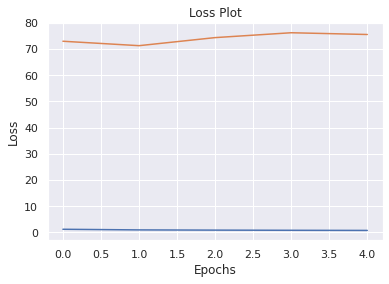

In [ ]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((maxlen, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(maxlen):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


In [ ]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 20))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

BELU score: 22.941313808356618
Real Caption: a group of people are gathered on a sidewalk in front of a store nearby a littered street
Prediction Caption: a group of people are walking down a street


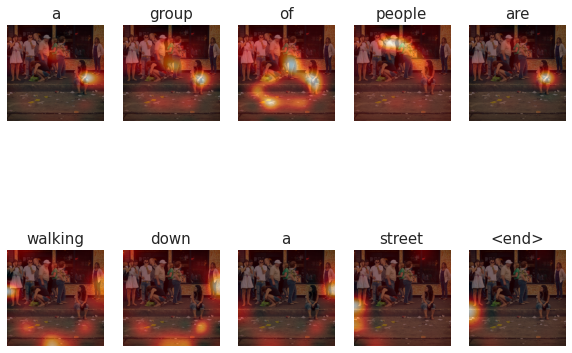

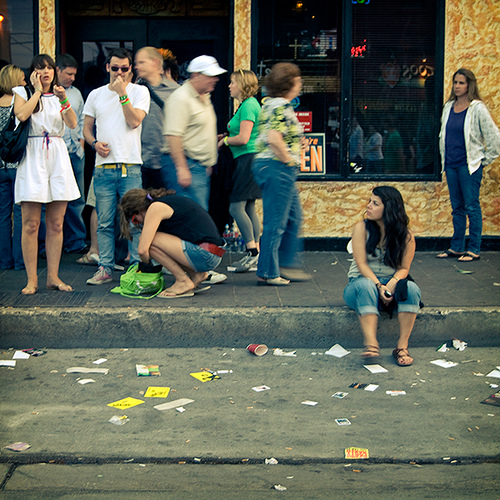

In [111]:
rid = np.random.randint(0, len(img_test))
test_image = img_test[rid]
# test_image = ''
# real_caption = ''

real_caption = ' '.join([tokenizer.index_word[i.numpy()] for i in cap_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0.5, 0.5))
print(f"BELU score: {score*100}")
print('Real Caption:', real_caption)
print('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image.numpy()) #.numpy()
Image.open(test_image.numpy()) #.numpy()
